In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
ctwdf = 'CTWD_ProcessData.xlsx'
cvf = 'CV_ProcessData.xlsx'

ctwd = pd.read_excel(ctwdf, usecols=lambda x: 'Unnamed' not in x)
cv = pd.read_excel(cvf, usecols=lambda x: 'Unnamed' not in x)

# Introduction
## Variables

### Common
 - dateTime: time for data collection
 - dataItemId: Data collection target info
 - BeadNumber: Effectively layer
 - value: item specified by dataItemId
 - beadtime (s): Length of time since starting that layer (note dwell)
 - buildTime (s): counter since start of data collection
 - Traverse Speed (mm/s): Constant in this build - speed of travel 
 - beadPosition (mm): derived measure based on buildTime*Traverse speed. 
 - MovAvgValue: Calculated 4 average of value

### CTWD only 
 - Reference value: Only used for CTWD - measure by which Value is offset by
 - ProcessValue_ref: I don't remember what this is

## Preprocessing
- Value outliers were removed based on 95% confidence interval
 - This filters for values that are weird at the start of a bead.
 
# Statistical Extraction

In [3]:
def extraction(grouped):
    mean = grouped.mean()
    skew = grouped.skew()
    std = grouped.std()
    mean.columns = ['mean_' + str(col) for col in mean.columns]
    skew.columns = ['skew_' + str(col) for col in skew.columns]
    std.columns = ['std_' + str(col) for col in std.columns]
    return mean.join([skew, std])

## Current / Voltage

In [4]:
cv.dropna(subset=['value'], ignore_index=True, inplace=True)
cv.drop(columns=['Traverse Speed (mm/s)', 'buildTime (s)', 'beadTime (s)', 
                     'dateTime', 'TimeDiff', 'beadPosition (mm)'], inplace=True,errors='ignore')
grouped =  cv.groupby(by=[ 'dataItemId','Power Setpoint (kW)', 'Dwell Time (s)','BeadNumber', ])
cv_statistics = extraction(grouped)
arcCurrent = cv_statistics.loc['Arc Current']
arcVoltage = cv_statistics.loc['Arc Voltage']

## Contact Tip Working Distance

In [5]:
ctwd.dropna(subset=['value'], ignore_index=True, inplace=True)
ctwd.drop(columns=['dataItemId','Traverse Speed (mm/s)', 'buildTime (s)', 'beadTime (s)', 
                 'dateTime',  'beadPosition (mm)', 'ReferenceValue'], inplace=True, errors='ignore')
ctwd_group =  ctwd.groupby(by=[ 'Power Setpoint (kW)', 'Dwell Time (s)','BeadNumber', ])
ctwd_statistics = extraction(ctwd_group)


## Save Values to XLSX

In [6]:
arcCurrent.to_excel('Current_Stats.xlsx')
arcVoltage.to_excel('Voltage_Stats.xlsx')
ctwd_statistics.to_excel('CTWD_Stats.xlsx')

# Plotting

<Figure size 1000x600 with 0 Axes>

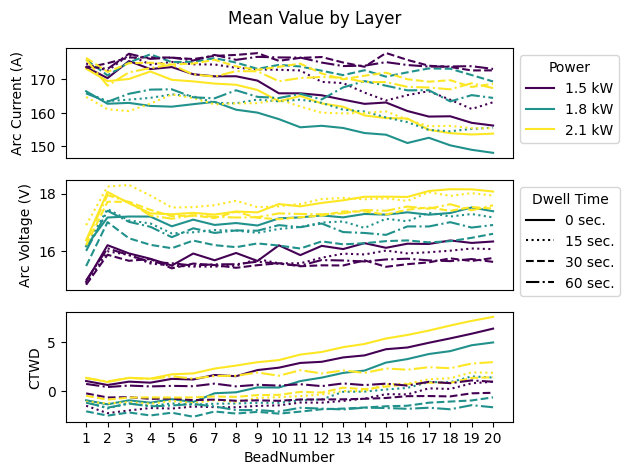

In [18]:
import numpy as np
import matplotlib.lines as mlines

powers = cv['Power Setpoint (kW)'].unique()
dwell_times = cv['Dwell Time (s)'].unique()
graphby = 'mean_value'
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(powers)))
lss = ['solid', 'dotted', 'dashed', 'dashdot']
color_lines = []
ls_lines = []
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
for ddx, dT in enumerate(dwell_times):    
    for idx, power in enumerate(powers):
        aC = arcCurrent.loc[(power, dT, slice(None)), :].reset_index()
        aV = arcVoltage.loc[(power, dT, slice(None)), :].reset_index()
        CTWD = ctwd_statistics.loc[(power, dT, slice(None)), :].reset_index()
        ax1.plot(aC['BeadNumber'], aC[graphby], color=colors[idx], linestyle=lss[ddx])
        ax2.plot(aV['BeadNumber'], aV[graphby], color=colors[idx], linestyle=lss[ddx])
        ax3.plot(CTWD['BeadNumber'], CTWD[graphby], color=colors[idx], linestyle=lss[ddx])

        if ddx == 0:
            color_lines.append(mlines.Line2D([], [], color=colors[idx], label=f'{power} kW'))
        if idx == 0:
            ls_lines.append(mlines.Line2D([], [], color='black', linestyle=lss[ddx], label=f'{dT} sec.'))

# Add the legends to one of the axes (or all of them if desired)
ax1.legend(handles=color_lines, bbox_to_anchor=(1, 1), title='Power')
ax2.legend(handles=ls_lines, bbox_to_anchor=(1, 1), title='Dwell Time')

fig.suptitle('V Value by Layer')
ax1.set_xticks([]), ax2.set_xticks([])
plt.xlabel('BeadNumber')
plt.xticks(np.arange(1,21))
ax1.set_ylabel('Arc Current (A)'), ax2.set_ylabel('Arc Voltage (V)')
ax3.set_ylabel('CTWD')
plt.tight_layout()
plt.savefig(f'{graphby}.png', dpi=300)
